In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ROOT_DIR = "/usr/local/google/home/ttrippel/Repos/hw-fuzzing/circuits/double_counter/data"
BYTE_STREAM_DIR = os.path.join(ROOT_DIR, "exp002_aflgo_byte_stream")
ONE_BPL_DIR = os.path.join(ROOT_DIR, "exp003_aflgo_1byte_per_line")
ONE_BPL_WCHECK_DIR = os.path.join(ROOT_DIR, "exp004_aflgo_1byte_per_line_wformatcheck")

In [4]:
vcd_titles = []
vcd_dfs = []
log_dfs = []
power_factor_dfs = []

# experiment parameters
input_formats = [BYTE_STREAM_DIR, ONE_BPL_DIR, ONE_BPL_WCHECK_DIR]
fuzz_times = [(10, 7), (60, 45), (120, 10)]
fuzzer_modes = ["m", "s"]

# Load VCD and Log data frames
for time in fuzz_times:
  for mode in fuzzer_modes:
    for format in input_formats:

      # Set VCD plot titles
      if format == BYTE_STREAM_DIR:
        format_title = "Byte Stream"
      elif format == ONE_BPL_DIR:
        format_title = "1-BPL"
      else:
        format_title = "1-BPL-wCheck"
      vcd_titles.append("%s; TTF: %dm; TTE: %dm; Mode: %s" % (format_title, time[0], time[1], mode))

      # Load VCD data
      vcd_path = os.path.join(format, "out/aflgo_%dm_%dttem_%s_1/vcd/data.json" % (time[0], time[1], mode))
      vcd_dfs.append(pd.read_json(vcd_path))

      # Create power factors data structure
      power_factor_dict = {"Input File" : list(range(max(vcd_dfs[-1]['Input File']) + 1)), "Power Factor" : (max(vcd_dfs[-1]['Input File']) + 1) * [0]}

      # Load log data
      log_path = os.path.join(format, "logs/aflgo_%dm_%dttem_%s_1.err.log" % (time[0], time[1], mode))
      log_dict = None
      with open(log_path, "r") as logf:
        i = 1
        for line in logf:
          line = line.rstrip()
          if i == 1:
            # header
            header_list = line.split(', ')
            log_dict = {k:[] for k in header_list}
          else:
            # data
            data_list = line.split(', ')
            log_dict['Time'].append(int(data_list[0]))
            log_dict['% Exploration Time'].append(float(data_list[1]))
            log_dict['T'].append(float(data_list[2]))
            log_dict['Distance'].append(float(data_list[3]))
            log_dict['Normalized Distance'].append(float(data_list[4]))
            log_dict['Power Factor'].append(float(data_list[5]))
            log_dict['Filename'].append(data_list[6])
            # parse input file name for power factors dict
            seed_file_num = int(log_dict['Filename'][-1].split('/')[-1].split(",")[0].lstrip("id:"))
            power_factor_dict["Power Factor"][seed_file_num] = log_dict['Power Factor'][-1]
          i += 1
      # Replace undefined distance measures with max values
      max_distance = max(log_dict['Distance'])
      max_norm_distance = max(log_dict['Normalized Distance']) 
      for i in range(len(log_dict['Distance'])):
        if log_dict['Distance'][i] < 0:
          # print("here-1")
          log_dict['Distance'][i] = max_distance
      for i in range(len(log_dict['Normalized Distance'])):
        if log_dict['Normalized Distance'][i] < 0:
          # print("here-2")
          log_dict['Normalized Distance'][i] = max_norm_distance

      # Generate log data frame
      log_dfs.append(pd.DataFrame.from_dict(log_dict))

      # Generate power factor data frame
      power_factor_dfs.append(pd.DataFrame.from_dict(power_factor_dict))

Saving plot to: /usr/local/google/home/ttrippel/Repos/hw-fuzzing/plots/exp003_double_counter_input_format_vcd.pdf


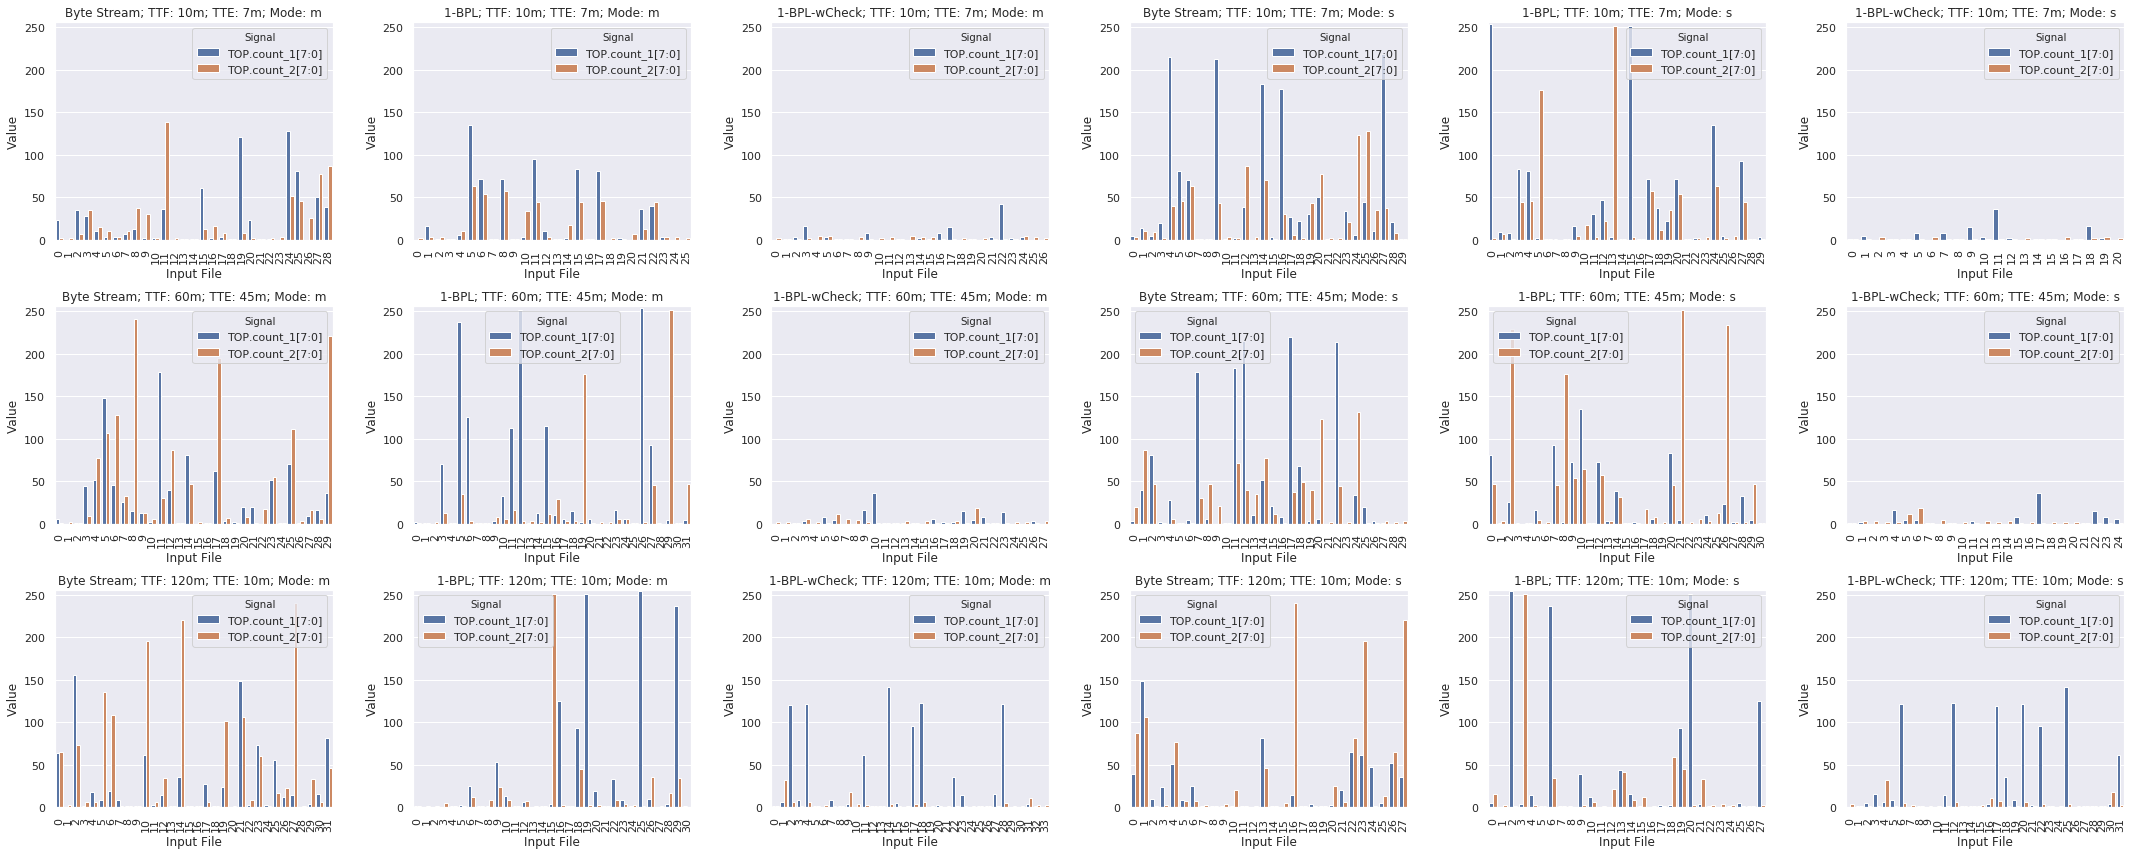

In [5]:
# Plot VCD data
NUM_ROWS = 3
NUM_COLS = 6
sns.set()
fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(30, 12));

# Plot register counts
for row in range(NUM_ROWS):
  for col in range(NUM_COLS):
    df_ind = (row * NUM_COLS) + (col % NUM_COLS)
    sns.barplot(x="Input File", y="Value", hue="Signal", data=vcd_dfs[df_ind], ax=axes[row][col])
    axes[row][col].set_ylim([0, 256])
    plt.setp(axes[row][col].xaxis.get_majorticklabels(), rotation=90)
    axes[row][col].set_title(vcd_titles[df_ind])

# Adjust layout of subplots to fit
plt.tight_layout();

# Save Plot as a PDF
plot_filename = "/usr/local/google/home/ttrippel/Repos/hw-fuzzing/plots/exp003_double_counter_input_format_vcd.pdf"
print("Saving plot to:", plot_filename)
plt.savefig(plot_filename, format='pdf')

Saving plot to: /usr/local/google/home/ttrippel/Repos/hw-fuzzing/plots/exp003_double_counter_input_format_power_factor.pdf


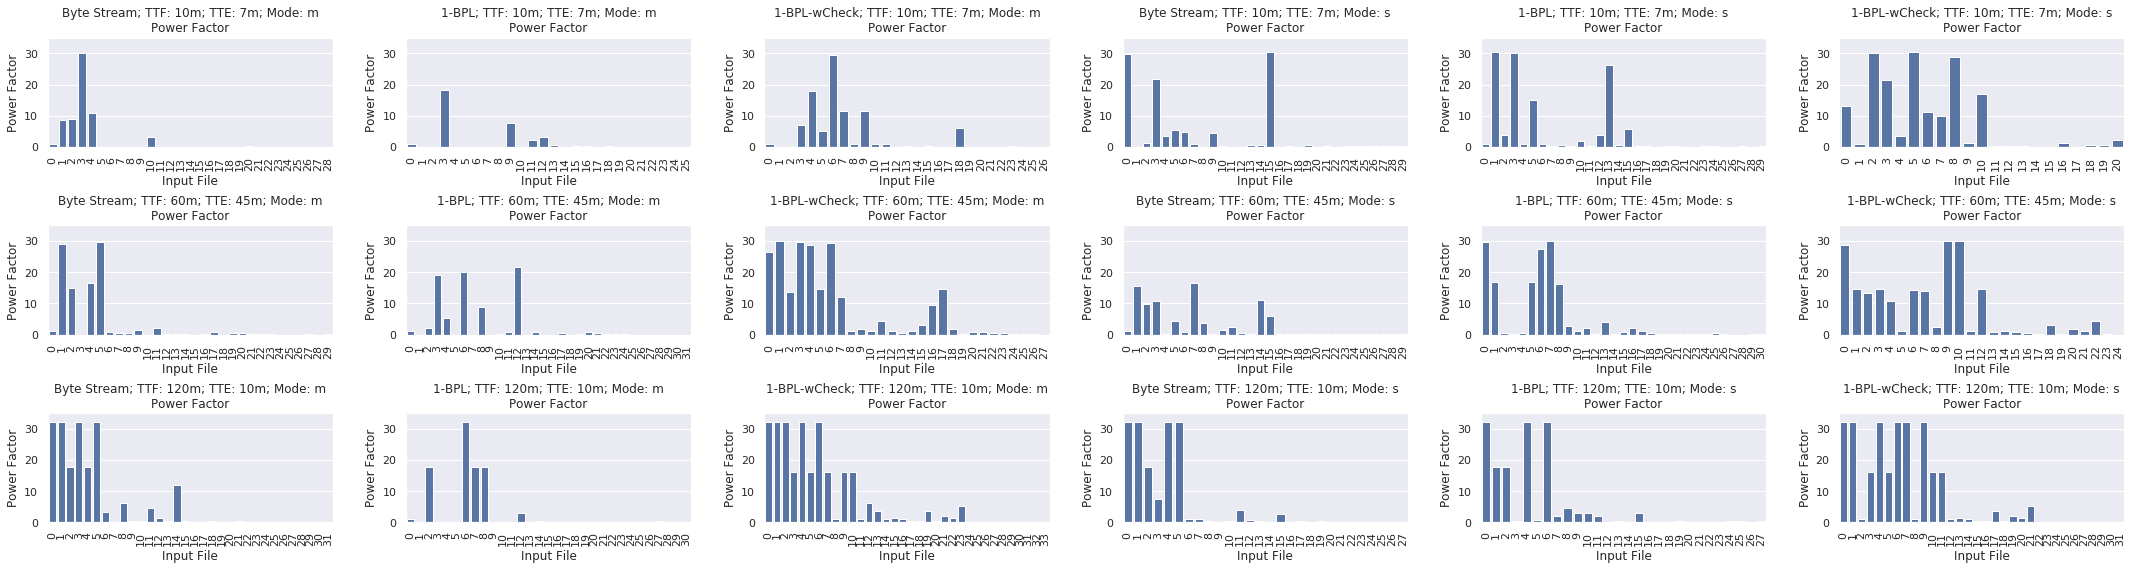

In [13]:
# Plot power factor data
NUM_ROWS = 3
NUM_COLS = 6
sns.set()
fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(30, 8));

# Plot register counts
for row in range(NUM_ROWS):
  for col in range(NUM_COLS):
    df_ind = (row * NUM_COLS) + (col % NUM_COLS)
    sns.barplot(x="Input File", y="Power Factor", data=power_factor_dfs[df_ind], ax=axes[row][col], color=sns.color_palette()[0])
    axes[row][col].set_ylim([0, 35])
    plt.setp(axes[row][col].xaxis.get_majorticklabels(), rotation=90)
    axes[row][col].set_title(vcd_titles[df_ind] + "\nPower Factor")

# Adjust layout of subplots to fit
plt.tight_layout();

# Save Plot as a PDF
plot_filename = "/usr/local/google/home/ttrippel/Repos/hw-fuzzing/plots/exp003_double_counter_input_format_power_factor.pdf"
print("Saving plot to:", plot_filename)
plt.savefig(plot_filename, format='pdf')

Saving plot to: /usr/local/google/home/ttrippel/Repos/hw-fuzzing/plots/exp003_double_counter_input_format_distance.pdf


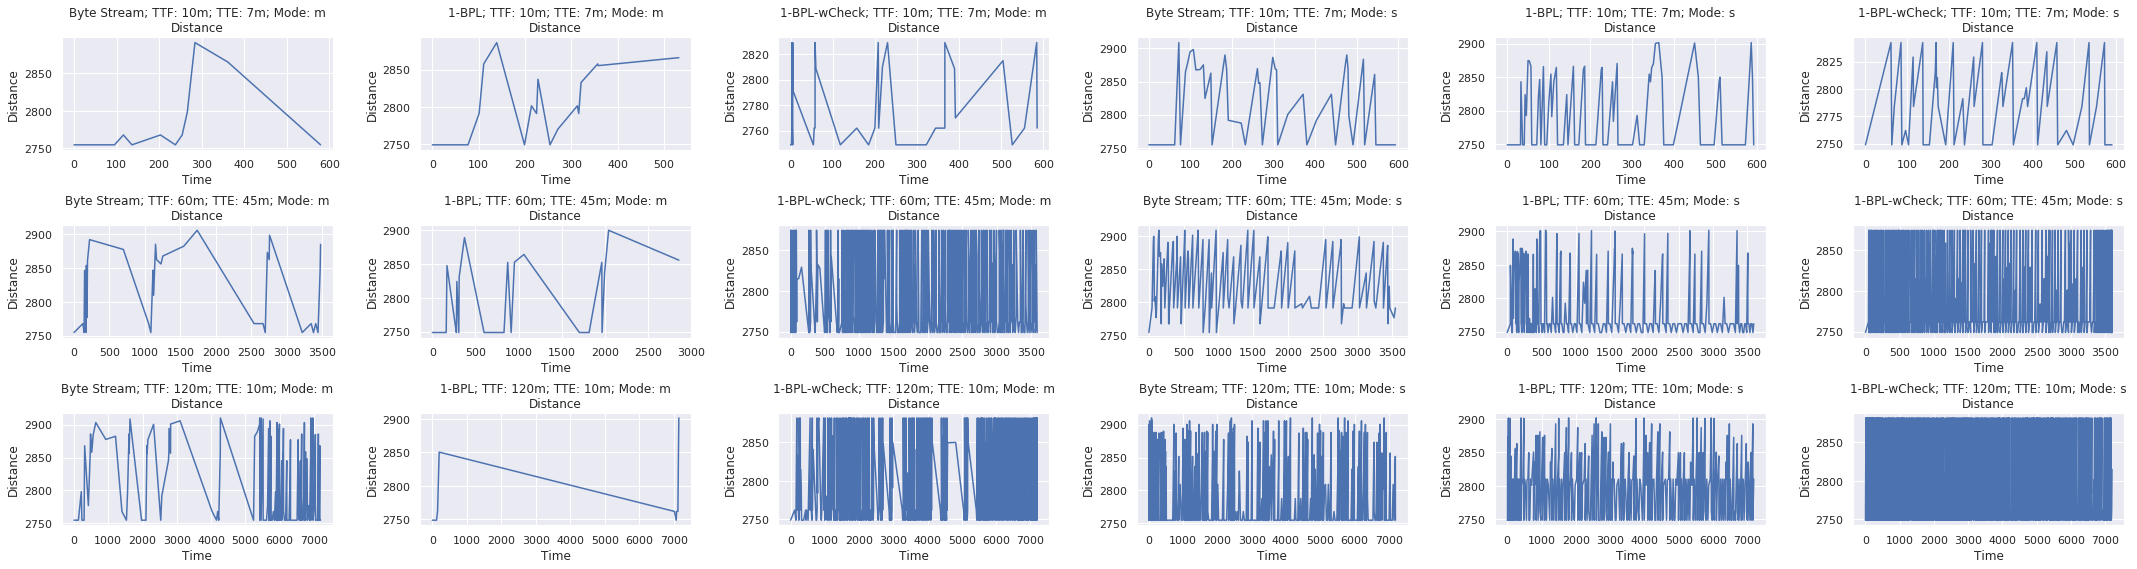

In [8]:
# Plot distance data
NUM_ROWS = 3
NUM_COLS = 6
sns.set()
fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(30, 8));

# Plot register counts
for row in range(NUM_ROWS):
  for col in range(NUM_COLS):
    df_ind = (row * NUM_COLS) + (col % NUM_COLS)
    sns.lineplot(x=log_dfs[df_ind]["Time"], y=log_dfs[df_ind]["Distance"], ax=axes[row][col], estimator=None)
    # axes[row][col].set_ylim([0, 3000])
    axes[row][col].set_title(vcd_titles[df_ind] + "\nDistance")

# Adjust layout of subplots to fit
plt.tight_layout();

# Save Plot as a PDF
plot_filename = "/usr/local/google/home/ttrippel/Repos/hw-fuzzing/plots/exp003_double_counter_input_format_distance.pdf"
print("Saving plot to:", plot_filename)
plt.savefig(plot_filename, format='pdf')

Saving plot to: /usr/local/google/home/ttrippel/Repos/hw-fuzzing/plots/exp003_double_counter_input_format_norm_distance.pdf


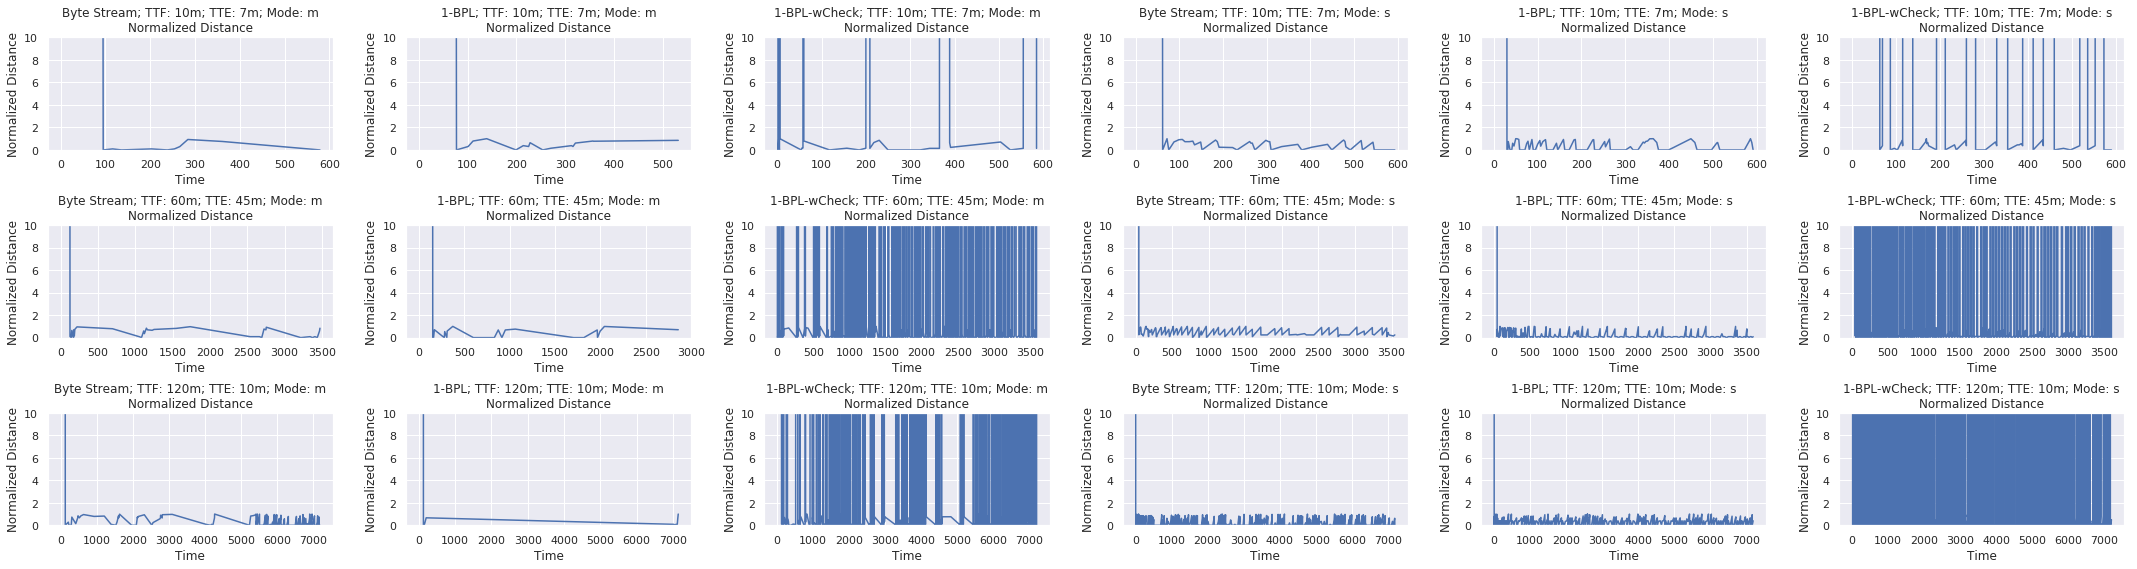

In [12]:
# Plot normalized distance data
NUM_ROWS = 3
NUM_COLS = 6
sns.set()
fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(30, 8));

# Plot register counts
for row in range(NUM_ROWS):
  for col in range(NUM_COLS):
    df_ind = (row * NUM_COLS) + (col % NUM_COLS)
    sns.lineplot(x=log_dfs[df_ind]["Time"], y=log_dfs[df_ind]["Normalized Distance"], ax=axes[row][col], estimator=None)
    axes[row][col].set_ylim([0, 10])
    axes[row][col].set_title(vcd_titles[df_ind] + "\nNormalized Distance")

# Adjust layout of subplots to fit
plt.tight_layout();

# Save Plot as a PDF
plot_filename = "/usr/local/google/home/ttrippel/Repos/hw-fuzzing/plots/exp003_double_counter_input_format_norm_distance.pdf"
print("Saving plot to:", plot_filename)
plt.savefig(plot_filename, format='pdf')